In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")


In [3]:

import os

!pip install -U duckduckgo_search
!pip install fastai
!pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 9.7 MB/s eta 0:00:0000:0100:01


In [4]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(term,max_results=max_images)
        return L(ddgs_images_gen).itemgot('image')

In [12]:
searches = 'fish','cat'
path = Path('fish_or_cat')
from time import sleep
from fastai.vision.all import *


for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'cute {o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'angry {o} photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'fish photo'
Searching for 'cute fish photo'
Searching for 'angry fish photo'
Searching for 'cat photo'
Searching for 'cute cat photo'
Searching for 'angry cat photo'


In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


2

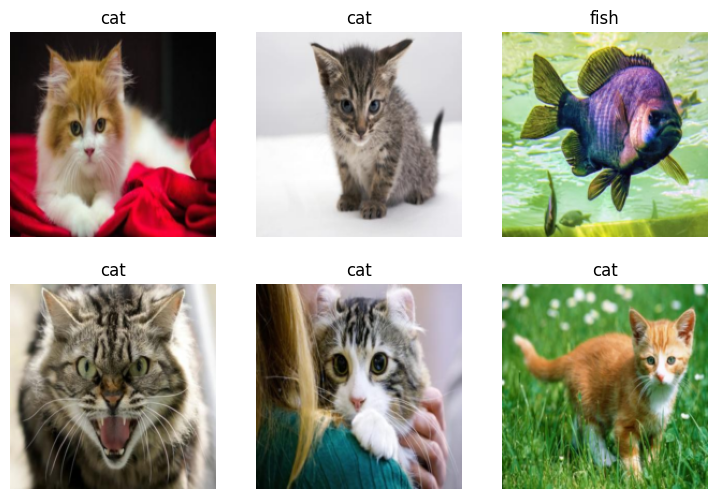

In [14]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.553191,0.014528,0.000000,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.038190,0.019504,0.015152,00:27
1,0.043766,0.008002,0.000000,00:26
2,0.027691,0.005075,0.000000,00:27


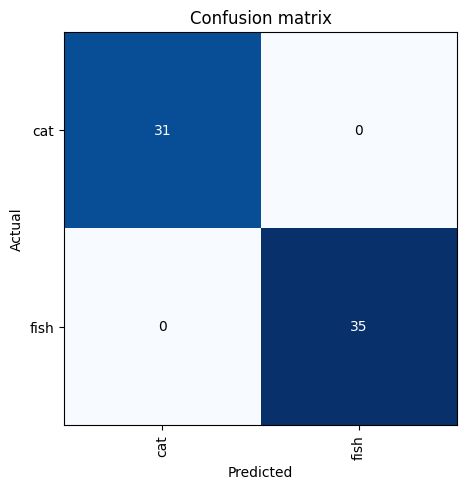

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

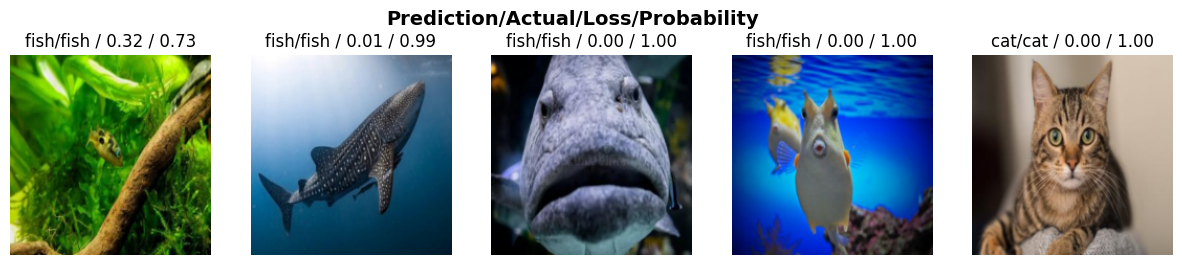

In [17]:
interp.plot_top_losses(5, nrows=1)

In [18]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [19]:
learn.export('model.pkl')